# Advanced Fake News Detection Model

## Indlæser datasættet
Indlæser og *Training_dataset.csv* og *Validation_dataset.csv* (dette er dog versionerne, hvor klasserne er grupperet under *fake* og *reliable*). Jeg indlæser dog kun ``type`` og ``cleaned content`` kolonnerne, da disse er de eneste der er tilladte at bruge i Part 3.

In [1]:
import pandas as pd

Training_Data = pd.read_csv('../Data/Training_dataset.csv', usecols=['type', 'cleaned content'])
Test_Data = pd.read_csv('../Data/Validation_dataset.csv', usecols=['type', 'cleaned content']) # her menes validation men skrives test ¯\_(ツ)_/¯

Training_Data

,type,cleaned content
0,reliable,"['publish', '<DATE>', '<URL>', 'trump', 'organ..."
1,reliable,"['bear', 'still', 'forc', 'worri', 'consum', '..."
2,fake,"['exit', 'poll', 'german', 'region', 'elect', ..."
3,reliable,"['photo', 'noah', 'feldman', 'highli', 'person..."
4,fake,"['refocu', 'note', 'read', 'stori', 'may', 'wo..."
...,...,...
573035,reliable,"['editor', 'dr', 'paulina', 'kernberg', 'state..."
573036,reliable,"['suggest', '<NUM>', 'tri', 'funni', 'pointer'..."
573037,fake,"['nation', 'id', 'resist', 'timothi', 'n', 'ba..."
573038,fake,"['reader', 'suggest', 'berni', 'madoff', 'must..."


Det fås at ud fra denne klasse fordeling, er datasættet praktisk talt balanceret (48% vs 52%).

Nu omskriver jeg de indlæste datasæt til variablerne jeg vil bruge (altså en anden form):

In [2]:
Training_Data = pd.DataFrame({'X':Training_Data['cleaned content'], 'Y':Training_Data['type']})
Test_Data = pd.DataFrame({'X':Test_Data['cleaned content'], 'Y':Test_Data['type']})

Training_Data

,X,Y
0,"['publish', '<DATE>', '<URL>', 'trump', 'organ...",reliable
1,"['bear', 'still', 'forc', 'worri', 'consum', '...",reliable
2,"['exit', 'poll', 'german', 'region', 'elect', ...",fake
3,"['photo', 'noah', 'feldman', 'highli', 'person...",reliable
4,"['refocu', 'note', 'read', 'stori', 'may', 'wo...",fake
...,...,...
573035,"['editor', 'dr', 'paulina', 'kernberg', 'state...",reliable
573036,"['suggest', '<NUM>', 'tri', 'funni', 'pointer'...",reliable
573037,"['nation', 'id', 'resist', 'timothi', 'n', 'ba...",fake
573038,"['reader', 'suggest', 'berni', 'madoff', 'must...",fake


## Input Repræsentationer

Importere ``CountVectorizer``, til at omdanne tokens til numerisk data, som kan trænes på.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

### Count Vector

In [4]:
CountVector = CountVectorizer(
    binary=True, 
    max_features=None).fit(Training_Data['X'])

CountVector_matrix = CountVector.transform(Training_Data['X'])

In [5]:
Bigram_CountVector = CountVectorizer(
    binary=True,
    ngram_range=(2, 2), 
    max_features=None).fit(Training_Data['X'])

Bigram_CountVector_matrix = Bigram_CountVector.transform(Training_Data['X'])

In [6]:
Multigram_CountVector = CountVectorizer(
    binary=True, 
    ngram_range=(1, 2), 
    max_features=None).fit(Training_Data['X'])

Multigram_CountVector_matrix = Multigram_CountVector.transform(Training_Data['X'])

### Bag Of Words

In [85]:
BagOfWords = CountVectorizer(
    binary=False, 
    max_features=None).fit(Training_Data['X'])

BagOfWords_matrix = BagOfWords.transform(Training_Data['X'])

In [86]:
Bigram_BagOfWords = CountVectorizer(
    binary=False, 
    ngram_range=(2, 2), 
    max_features=None).fit(Training_Data['X'])

Bigram_BagOfWords_matrix = Bigram_BagOfWords.transform(Training_Data['X'])

In [87]:
Multigram_BagOfWords = CountVectorizer(
    binary=False, 
    ngram_range=(1, 2), 
    max_features=None).fit(Training_Data['X'])

Multigram_BagOfWords_matrix = Multigram_BagOfWords.transform(Training_Data['X'])

### TF-IDF transformation

In [7]:
from sklearn.feature_extraction.text import TfidfTransformer

In [8]:
TFIDF_CountVector = TfidfTransformer().fit(CountVector_matrix)

TFIDF_Bigram_CountVector = TfidfTransformer().fit(Bigram_CountVector_matrix)

TFIDF_Multigram_CountVector = TfidfTransformer().fit(Multigram_CountVector_matrix)

In [88]:
TFIDF_BagOfWords = TfidfTransformer().fit(BagOfWords_matrix)

TFIDF_Bigram_BagOfWords = TfidfTransformer().fit(Bigram_BagOfWords_matrix)

TFIDF_Multigram_BagOfWords = TfidfTransformer().fit(Multigram_BagOfWords_matrix)

### Chi feature selection

In [9]:
from sklearn.feature_selection import SelectFpr, chi2

In [10]:
Chi_CountVector = SelectFpr(chi2, alpha=0.50).fit(CountVector_matrix, Training_Data['Y'])

Chi_Bigram_CountVector = SelectFpr(chi2, alpha=0.42).fit(Bigram_CountVector_matrix, Training_Data['Y'])

Chi_Multigram_CountVector = SelectFpr(chi2, alpha=0.35).fit(Multigram_CountVector_matrix, Training_Data['Y'])

In [89]:
Chi_BagOfWords = SelectFpr(chi2, alpha=0.50).fit(BagOfWords_matrix, Training_Data['Y'])

Chi_Bigram_BagOfWords = SelectFpr(chi2, alpha=0.42).fit(Bigram_BagOfWords_matrix, Training_Data['Y'])

Chi_Multigram_BagOfWords = SelectFpr(chi2, alpha=0.35).fit(Multigram_BagOfWords_matrix, Training_Data['Y'])

#### Selection α (CountVector)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

Unigram_alpha_outputs = {
    'alpha':[0.1, 0.25, 0.4, 0.5, 0.6, 0.75],
    'fake':list(),
    'reliable':list()
    }

for i in Unigram_alpha_outputs['alpha']:
    selector = SelectFpr(chi2, alpha=i).fit(CountVector_matrix, Training_Data['Y'])

    # Initializing and training the model
    LogReg_model = LogisticRegression(max_iter=10000)
    LogReg_model.fit(selector.transform(CountVector_matrix), Training_Data['Y'])

    # Testing the model
    predictions = LogReg_model.predict(selector.transform(CountVector.transform(Test_Data['X'])))
    result = classification_report(Test_Data['Y'], predictions, digits=5, output_dict=True)

    # saving the data
    Unigram_alpha_outputs['fake'].append(result['fake']['f1-score'])
    Unigram_alpha_outputs['reliable'].append(result['reliable']['f1-score'])

In [72]:
Unigram_alpha_outputs

{'alpha': [0.1, 0.25, 0.4, 0.5, 0.6, 0.75],
 'fake': [0.8605272428370127,
  0.8619633250758564,
  0.8621028400510241,
  0.8621048771543821,
  0.8619642254471819,
  0.8617008797653959],
 'reliable': [0.8735292551775542,
  0.8745052572662215,
  0.8746952316239658,
  0.8747952320703203,
  0.8747586904714356,
  0.8743405275779377]}

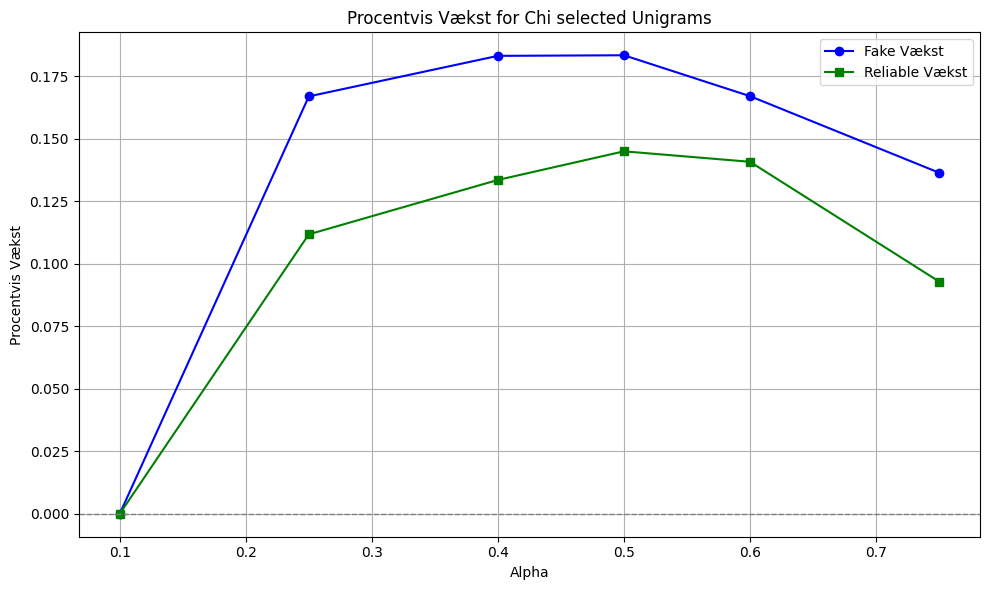

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# Konverter data til NumPy arrays
alpha = np.array(Unigram_alpha_outputs['alpha'])
fake = np.array(Unigram_alpha_outputs['fake'])
reliable = np.array(Unigram_alpha_outputs['reliable'])

# Beregn procentvis vækst i forhold til første værdi
fake_growth = ((fake - fake[0]) / fake[0]) * 100
reliable_growth = ((reliable - reliable[0]) / reliable[0]) * 100

# Plot vækst
plt.figure(figsize=(10, 6))
plt.plot(alpha, fake_growth, label='Fake Vækst', marker='o', color='blue')
plt.plot(alpha, reliable_growth, label='Reliable Vækst', marker='s', color='green')

# Tilføj labels og layout
plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # Nul-linje for reference
plt.xlabel('Alpha')
plt.ylabel('Procentvis Vækst')
plt.title('Procentvis Vækst for Chi selected Unigrams')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

Multigram_alpha_outputs = {
    'alpha':[0.1, 0.25, 0.30, 0.35, 0.4, 0.5, 0.6, 0.75],
    'fake':list(),
    'reliable':list()
    }

for i in Multigram_alpha_outputs['alpha']:
    selector = SelectFpr(chi2, alpha=i).fit(Multigram_CountVector_matrix, Training_Data['Y'])

    # Initializing and training the model
    LogReg_model = LogisticRegression(max_iter=10000)
    LogReg_model.fit(selector.transform(Multigram_CountVector_matrix), Training_Data['Y'])

    # Testing the model
    predictions = LogReg_model.predict(selector.transform(Multigram_CountVector.transform(Test_Data['X'])))
    result = classification_report(Test_Data['Y'], predictions, digits=5, output_dict=True)

    # saving the data
    Multigram_alpha_outputs['fake'].append(result['fake']['f1-score'])
    Multigram_alpha_outputs['reliable'].append(result['reliable']['f1-score'])

In [74]:
Multigram_alpha_outputs

{'alpha': [0.1, 0.25, 0.3, 0.35, 0.4, 0.5, 0.6, 0.75],
 'fake': [0.8932480289141175,
  0.8934165621445032,
  0.8929994980660781,
  0.8952583879394638,
  0.8948074679113186,
  0.8945594607607126,
  0.8940141976570944,
  0.894508733783764],
 'reliable': [0.9018662165239875,
  0.9021608161298096,
  0.9040279653610869,
  0.9039724909351209,
  0.9034538152610442,
  0.9032776134584243,
  0.9029920586111928,
  0.9032689708696292]}

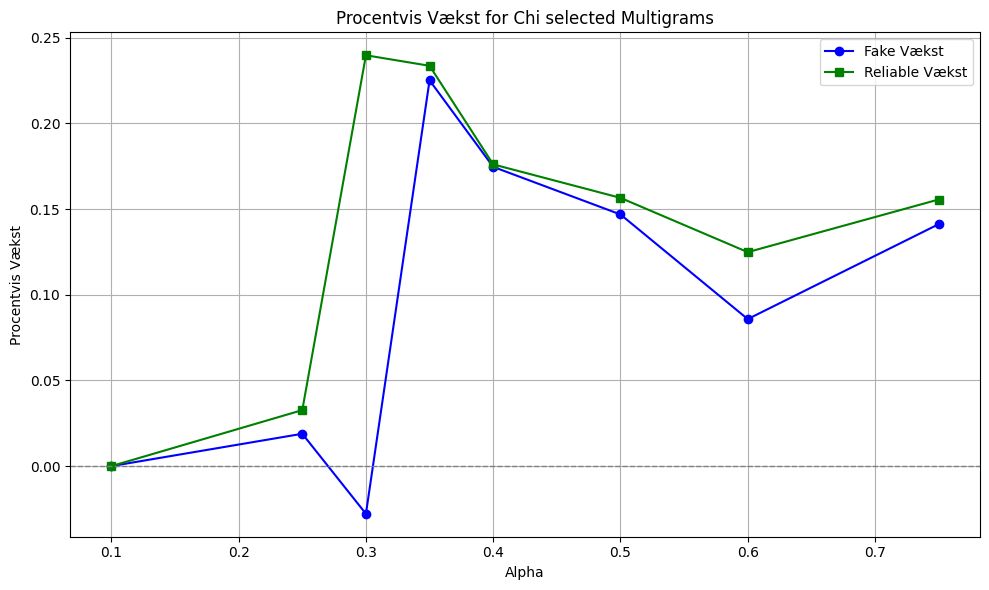

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Konverter data til NumPy arrays
alpha = np.array(Multigram_alpha_outputs['alpha'])
fake = np.array(Multigram_alpha_outputs['fake'])
reliable = np.array(Multigram_alpha_outputs['reliable'])

# Beregn procentvis vækst i forhold til første værdi
fake_growth = ((fake - fake[0]) / fake[0]) * 100
reliable_growth = ((reliable - reliable[0]) / reliable[0]) * 100

# Plot vækst
plt.figure(figsize=(10, 6))
plt.plot(alpha, fake_growth, label='Fake Vækst', marker='o', color='blue')
plt.plot(alpha, reliable_growth, label='Reliable Vækst', marker='s', color='green')

# Tilføj labels og layout
plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # Nul-linje for reference
plt.xlabel('Alpha')
plt.ylabel('Procentvis Vækst')
plt.title('Procentvis Vækst for Chi selected Multigrams')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


## Base Model

Base model, svare til den model vi ville ende op med i Part 2 af opgaven. Da det i opgavespecifikationen ikke er blevet tydeliggjort hvordan teksten skal repræsenteres for modellen, andet at det skal være simpelt, er 2 måder givet: en Count Vector og en Bag Of Words.

Denne model opfylder at den trænes på de 10.000 mest hyppige unigrams, altså ord, som forekommer i trænings sættet.

### Count Vector

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

Base_CountVector = CountVectorizer(
    binary=True, 
    max_features=10000).fit(Training_Data['X'])

# Initializing and training the model
Base_model = LogisticRegression(max_iter=10000)
Base_model.fit(Base_CountVector.transform(Training_Data['X']), Training_Data['Y'])

# Testing the model
predictions = Base_model.predict(Base_CountVector.transform(Test_Data['X']))
result = classification_report(Test_Data['Y'], predictions, output_dict=True)
print(f'Fake     : {result['fake']['f1-score']}')
print(f'Reliable : {result['reliable']['f1-score']}')

Fake     : 0.8445050834030192
Reliable : 0.8588625377844654


### Bag Of Words

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

Base_BagOfWords = CountVectorizer(
    binary=False, 
    max_features=10000).fit(Training_Data['X'])

# Initializing and training the model
Base_model = LogisticRegression(max_iter=10000)
Base_model.fit(Base_BagOfWords.transform(Training_Data['X']), Training_Data['Y'])

# Testing the model
predictions = Base_model.predict(Base_BagOfWords.transform(Test_Data['X']))
result = classification_report(Test_Data['Y'], predictions, output_dict=True)
print(f'Fake     : {result['fake']['f1-score']}')
print(f'Reliable : {result['reliable']['f1-score']}')

Fake     : 0.8289200224944375
Reliable : 0.8471258256924163


## Logistisk Regression

Initialisere bibliotekerne brugt til den logistiske regression

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

### Count Vector

#### Raw vector

In [13]:
# Initializing and training the model
LogReg_model = LogisticRegression(max_iter=10000)
LogReg_model.fit(CountVector_matrix, Training_Data['Y'])

# Testing the model
predictions = LogReg_model.predict(CountVector.transform(Test_Data['X']))
result = classification_report(Test_Data['Y'], predictions, digits=5, output_dict=True)
print(f'Fake     : {result['fake']['f1-score']}')
print(f'Reliable : {result['reliable']['f1-score']}')

Fake     : 0.8622965244170699
Reliable : 0.8749167443719196


In [14]:
# Initializing and training the model
LogReg_model = LogisticRegression(max_iter=10000)
LogReg_model.fit(Bigram_CountVector_matrix, Training_Data['Y'])

# Testing the model
predictions = LogReg_model.predict(Bigram_CountVector.transform(Test_Data['X']))
result = classification_report(Test_Data['Y'], predictions, digits=5, output_dict=True)
print(f'Fake     : {result['fake']['f1-score']}')
print(f'Reliable : {result['reliable']['f1-score']}')

Fake     : 0.881616771683266
Reliable : 0.8903767040413003


In [15]:
# Initializing and training the model
LogReg_model = LogisticRegression(max_iter=10000)
LogReg_model.fit(Multigram_CountVector_matrix, Training_Data['Y'])

# Testing the model
predictions = LogReg_model.predict(Multigram_CountVector.transform(Test_Data['X']))
result = classification_report(Test_Data['Y'], predictions, digits=5, output_dict=True)
print(f'Fake     : {result['fake']['f1-score']}')
print(f'Reliable : {result['reliable']['f1-score']}')

Fake     : 0.8950048885840618
Reliable : 0.9037239238355211


#### TF-IDF transformation

In [16]:
# Initializing and training the model
LogReg_model = LogisticRegression(max_iter=10000)
LogReg_model.fit(TFIDF_CountVector.transform(CountVector_matrix), Training_Data['Y'])

# Testing the model
predictions = LogReg_model.predict(TFIDF_CountVector.transform(CountVector.transform(Test_Data['X'])))
result = classification_report(Test_Data['Y'], predictions, digits=5, output_dict=True)
print(f'Fake     : {result['fake']['f1-score']}')
print(f'Reliable : {result['reliable']['f1-score']}')

Fake     : 0.8627491267721389
Reliable : 0.875509171747291


In [17]:
# Initializing and training the model
LogReg_model = LogisticRegression(max_iter=10000)
LogReg_model.fit(TFIDF_Bigram_CountVector.transform(Bigram_CountVector_matrix), Training_Data['Y'])

# Testing the model
predictions = LogReg_model.predict(TFIDF_Bigram_CountVector.transform(Bigram_CountVector.transform(Test_Data['X'])))
result = classification_report(Test_Data['Y'], predictions, digits=5, output_dict=True)
print(f'Fake     : {result['fake']['f1-score']}')
print(f'Reliable : {result['reliable']['f1-score']}')

Fake     : 0.8719086041116477
Reliable : 0.8825127470792126


In [18]:
# Initializing and training the model
LogReg_model = LogisticRegression(max_iter=10000)
LogReg_model.fit(TFIDF_Multigram_CountVector.transform(Multigram_CountVector_matrix), Training_Data['Y'])

# Testing the model
predictions = LogReg_model.predict(TFIDF_Multigram_CountVector.transform(Multigram_CountVector.transform(Test_Data['X'])))
result = classification_report(Test_Data['Y'], predictions, digits=5, output_dict=True)
print(f'Fake     : {result['fake']['f1-score']}')
print(f'Reliable : {result['reliable']['f1-score']}')

Fake     : 0.8819726445105771
Reliable : 0.8927205617812838


#### Chi feature selection

In [67]:
# Initializing and training the model
LogReg_model = LogisticRegression(max_iter=10000)
LogReg_model.fit(Chi_CountVector.transform(CountVector_matrix), Training_Data['Y'])

# Testing the model
predictions = LogReg_model.predict(Chi_CountVector.transform(CountVector.transform(Test_Data['X'])))
result = classification_report(Test_Data['Y'], predictions, digits=5, output_dict=True)
print(f'Fake     : {result['fake']['f1-score']}')
print(f'Reliable : {result['reliable']['f1-score']}')

Fake     : 0.8621048771543821
Reliable : 0.8747952320703203


In [20]:
# Initializing and training the model
LogReg_model = LogisticRegression(max_iter=10000)
LogReg_model.fit(Chi_Bigram_CountVector.transform(Bigram_CountVector_matrix), Training_Data['Y'])

# Testing the model
predictions = LogReg_model.predict(Chi_Bigram_CountVector.transform(Bigram_CountVector.transform(Test_Data['X'])))
result = classification_report(Test_Data['Y'], predictions, digits=5, output_dict=True)
print(f'Fake     : {result['fake']['f1-score']}')
print(f'Reliable : {result['reliable']['f1-score']}')

Fake     : 0.882010482149857
Reliable : 0.8907382261599064


In [68]:
# Initializing and training the model
LogReg_model = LogisticRegression(max_iter=10000)
LogReg_model.fit(Chi_Multigram_CountVector.transform(Multigram_CountVector_matrix), Training_Data['Y'])

# Testing the model
predictions = LogReg_model.predict(Chi_Multigram_CountVector.transform(Multigram_CountVector.transform(Test_Data['X'])))
result = classification_report(Test_Data['Y'], predictions, digits=5, output_dict=True)
print(f'Fake     : {result['fake']['f1-score']}')
print(f'Reliable : {result['reliable']['f1-score']}')

Fake     : 0.8952583879394638
Reliable : 0.9039724909351209


#### Hyper-parameters

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

Multigram_C_outputs = {
    'C':[0.01, 0.1, 0.5, 1, 1.5, 2, 10],
    'fake':list(),
    'reliable':list()
    }

for i in Multigram_C_outputs['C']:
    # Initializing and training the model
    LogReg_model = LogisticRegression(max_iter=10000, C=i)
    LogReg_model.fit(Chi_Multigram_CountVector.transform(Multigram_CountVector_matrix), Training_Data['Y'])

    # Testing the model
    predictions = LogReg_model.predict(Chi_Multigram_CountVector.transform(Multigram_CountVector.transform(Test_Data['X'])))
    result = classification_report(Test_Data['Y'], predictions, digits=5, output_dict=True)

    # saving the data
    Multigram_C_outputs['fake'].append(result['fake']['f1-score'])
    Multigram_C_outputs['reliable'].append(result['reliable']['f1-score'])

In [83]:
Multigram_C_outputs

{'C': [0.01, 0.05, 0.1, 0.5, 1, 1.5, 2, 10],
 'fake': [0.8892850879756825,
  0.896659509516089,
  0.8967954897321299,
  0.8959637982629005,
  0.8941928702811597,
  0.8949310772372547,
  0.8942778814745683,
  0.8955114913997021],
 'reliable': [0.8987598888176181,
  0.9054106448119577,
  0.9055271813247052,
  0.9046618955253829,
  0.9030471655207469,
  0.9035807509537515,
  0.9029243211397354,
  0.9042982855003076]}

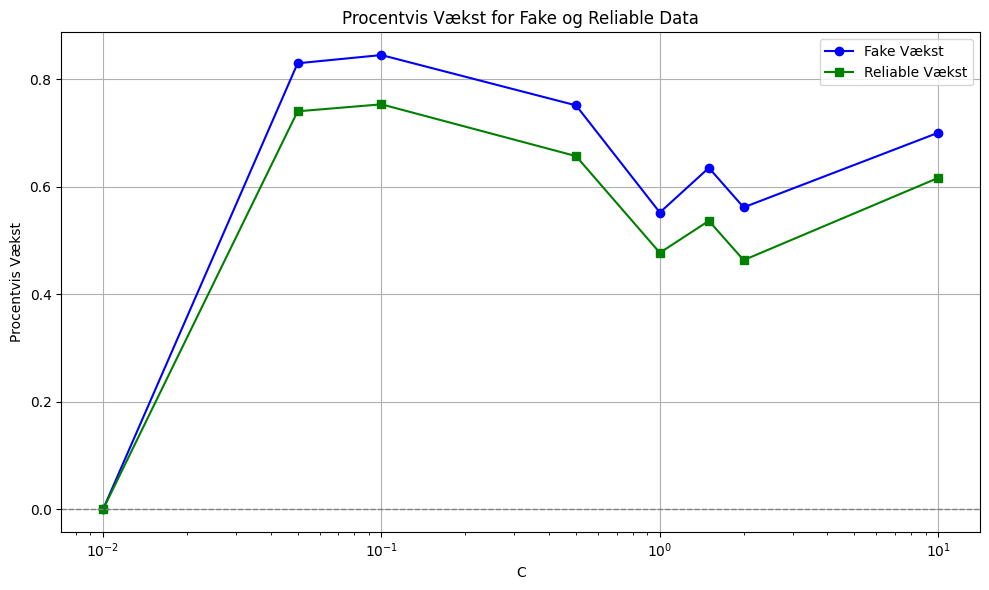

In [84]:
import numpy as np
import matplotlib.pyplot as plt

# Konverter data til NumPy arrays
C = np.array(Multigram_C_outputs['C'])
fake = np.array(Multigram_C_outputs['fake'])
reliable = np.array(Multigram_C_outputs['reliable'])

# Beregn procentvis vækst i forhold til første værdi
fake_growth = ((fake - fake[0]) / fake[0]) * 100
reliable_growth = ((reliable - reliable[0]) / reliable[0]) * 100

# Plot vækst
plt.figure(figsize=(10, 6))
plt.plot(C, fake_growth, label='Fake Vækst', marker='o', color='blue')
plt.plot(C, reliable_growth, label='Reliable Vækst', marker='s', color='green')

plt.xscale('log')

# Tilføj labels og layout
plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # Nul-linje for reference
plt.xlabel('C')
plt.ylabel('Procentvis Vækst')
plt.title('Procentvis Vækst for Fake og Reliable Data')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [69]:
# Initializing and training the model
LogReg_model = LogisticRegression(max_iter=10000, C=0.1)
LogReg_model.fit(Chi_Multigram_CountVector.transform(Multigram_CountVector_matrix), Training_Data['Y'])

# Testing the model
predictions = LogReg_model.predict(Chi_Multigram_CountVector.transform(Multigram_CountVector.transform(Test_Data['X'])))
result = classification_report(Test_Data['Y'], predictions, digits=5, output_dict=True)
print(f'Fake     : {result['fake']['f1-score']}')
print(f'Reliable : {result['reliable']['f1-score']}')

Fake     : 0.8970360636589283
Reliable : 0.9056840979002274


### Bag Of Words Vector

#### Raw vector

In [90]:
# Initializing and training the model
LogReg_model = LogisticRegression(max_iter=10000)
LogReg_model.fit(BagOfWords_matrix, Training_Data['Y'])

# Testing the model
predictions = LogReg_model.predict(BagOfWords.transform(Test_Data['X']))
result = classification_report(Test_Data['Y'], predictions, digits=5, output_dict=True)
print(f'Fake     : {result['fake']['f1-score']}')
print(f'Reliable : {result['reliable']['f1-score']}')

Fake     : 0.8435748467065693
Reliable : 0.8573411453815046


In [91]:
# Initializing and training the model
LogReg_model = LogisticRegression(max_iter=10000)
LogReg_model.fit(Bigram_BagOfWords_matrix, Training_Data['Y'])

# Testing the model
predictions = LogReg_model.predict(Bigram_BagOfWords.transform(Test_Data['X']))
result = classification_report(Test_Data['Y'], predictions, digits=5, output_dict=True)
print(f'Fake     : {result['fake']['f1-score']}')
print(f'Reliable : {result['reliable']['f1-score']}')

Fake     : 0.8776025053644957
Reliable : 0.8863611888864958


In [92]:
# Initializing and training the model
LogReg_model = LogisticRegression(max_iter=10000)
LogReg_model.fit(Multigram_BagOfWords_matrix, Training_Data['Y'])

# Testing the model
predictions = LogReg_model.predict(Multigram_BagOfWords.transform(Test_Data['X']))
result = classification_report(Test_Data['Y'], predictions, digits=5, output_dict=True)
print(f'Fake     : {result['fake']['f1-score']}')
print(f'Reliable : {result['reliable']['f1-score']}')

Fake     : 0.888316376286334
Reliable : 0.8970854513996003


#### TF-IDF transformation

In [93]:
# Initializing and training the model
LogReg_model = LogisticRegression(max_iter=10000)
LogReg_model.fit(TFIDF_BagOfWords.transform(BagOfWords_matrix), Training_Data['Y'])

# Testing the model
predictions = LogReg_model.predict(TFIDF_BagOfWords.transform(BagOfWords.transform(Test_Data['X'])))
result = classification_report(Test_Data['Y'], predictions, digits=5, output_dict=True)
print(f'Fake     : {result['fake']['f1-score']}')
print(f'Reliable : {result['reliable']['f1-score']}')

Fake     : 0.8506330599609747
Reliable : 0.8644322827201427


In [94]:
# Initializing and training the model
LogReg_model = LogisticRegression(max_iter=10000)
LogReg_model.fit(TFIDF_Bigram_BagOfWords.transform(Bigram_BagOfWords_matrix), Training_Data['Y'])

# Testing the model
predictions = LogReg_model.predict(TFIDF_Bigram_BagOfWords.transform(Bigram_BagOfWords.transform(Test_Data['X'])))
result = classification_report(Test_Data['Y'], predictions, digits=5, output_dict=True)
print(f'Fake     : {result['fake']['f1-score']}')
print(f'Reliable : {result['reliable']['f1-score']}')

Fake     : 0.8713412860052371
Reliable : 0.8813204508856682


In [95]:
# Initializing and training the model
LogReg_model = LogisticRegression(max_iter=10000)
LogReg_model.fit(TFIDF_Multigram_BagOfWords.transform(Multigram_BagOfWords_matrix), Training_Data['Y'])

# Testing the model
predictions = LogReg_model.predict(TFIDF_Multigram_BagOfWords.transform(Multigram_BagOfWords.transform(Test_Data['X'])))
result = classification_report(Test_Data['Y'], predictions, digits=5, output_dict=True)
print(f'Fake     : {result['fake']['f1-score']}')
print(f'Reliable : {result['reliable']['f1-score']}')

Fake     : 0.877323528980943
Reliable : 0.8883199317251403


#### Chi feature selection

In [96]:
# Initializing and training the model
LogReg_model = LogisticRegression(max_iter=10000)
LogReg_model.fit(Chi_BagOfWords.transform(BagOfWords_matrix), Training_Data['Y'])

# Testing the model
predictions = LogReg_model.predict(Chi_BagOfWords.transform(BagOfWords.transform(Test_Data['X'])))
result = classification_report(Test_Data['Y'], predictions, digits=5, output_dict=True)
print(f'Fake     : {result['fake']['f1-score']}')
print(f'Reliable : {result['reliable']['f1-score']}')

Fake     : 0.8441081334250545
Reliable : 0.857867275177816


In [ ]:
# Initializing and training the model
LogReg_model = LogisticRegression(max_iter=10000)
LogReg_model.fit(Chi_Bigram_BagOfWords.transform(Bigram_BagOfWords_matrix), Training_Data['Y'])

# Testing the model
predictions = LogReg_model.predict(Chi_Bigram_BagOfWords.transform(Bigram_BagOfWords.transform(Test_Data['X'])))
result = classification_report(Test_Data['Y'], predictions, digits=5, output_dict=True)
print(f'Fake     : {result['fake']['f1-score']}')
print(f'Reliable : {result['reliable']['f1-score']}')

In [ ]:
# Initializing and training the model
LogReg_model = LogisticRegression(max_iter=10000)
LogReg_model.fit(Chi_Multigram_BagOfWords.transform(Multigram_BagOfWords_matrix), Training_Data['Y'])

# Testing the model
predictions = LogReg_model.predict(Chi_Multigram_BagOfWords.transform(Multigram_BagOfWords.transform(Test_Data['X'])))
result = classification_report(Test_Data['Y'], predictions, digits=5, output_dict=True)
print(f'Fake     : {result['fake']['f1-score']}')
print(f'Reliable : {result['reliable']['f1-score']}')

## Best Model

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

Multigram_CountVector = CountVectorizer(
    binary=True, 
    ngram_range=(1, 2), 
    max_features=None).fit(Training_Data['X'])

Multigram_CountVector_matrix = Multigram_CountVector.transform(Training_Data['X'])

In [4]:
from sklearn.feature_selection import SelectFpr, chi2

Chi_Multigram_CountVector = SelectFpr(chi2, alpha=0.35).fit(Multigram_CountVector_matrix, Training_Data['Y'])

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initializing and training the model
LogReg_model = LogisticRegression(max_iter=10000, C=0.1)
LogReg_model.fit(Chi_Multigram_CountVector.transform(Multigram_CountVector_matrix), Training_Data['Y'])

# Testing the model
predictions = LogReg_model.predict(Chi_Multigram_CountVector.transform(Multigram_CountVector.transform(Test_Data['X'])))
result = classification_report(Test_Data['Y'], predictions, digits=5, output_dict=True)
print(f'Fake     : {result['fake']['f1-score']}')
print(f'Reliable : {result['reliable']['f1-score']}')

Fake     : 0.8970360636589283
Reliable : 0.9056840979002274


### Saving the Model

In [ ]:
import joblib

# getting the things to be saved
vectorizer  = Multigram_CountVector
selector    = Chi_Multigram_CountVector
model       = LogReg_model

# saving the vectorizer, feature selector and model to disk
joblib.dump(vectorizer, 'Advanced_vectorizer.pkl')
joblib.dump(selector, 'Advanced_selector.pkl')
joblib.dump(model, 'Advanced_model.pkl')

['Advanced_model.pkl']

### Reading the Model

In [14]:
# reading the vectorizer, feature selector and model
vectorizer  = joblib.load('Advanced_vectorizer.pkl')
selector    = joblib.load('Advanced_selector.pkl')
model       = joblib.load('Advanced_model.pkl')

## Testing different models

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    binary=True, 
    max_features=10_000).fit(Training_Data['X'][:5_000])

### Logisitc regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# training the model
model = LogisticRegression()
model.fit(
    vectorizer.transform(Training_Data['X'][:5_000]), 
    Training_Data['Y'][:5_000])

# testing the model
y_pred = model.predict(vectorizer.transform(Test_Data['X'][:5_000]))
print(classification_report(Test_Data['Y'][:5_000], y_pred))

              precision    recall  f1-score   support

        fake       0.76      0.77      0.76      2415
    reliable       0.78      0.77      0.78      2585

    accuracy                           0.77      5000
   macro avg       0.77      0.77      0.77      5000
weighted avg       0.77      0.77      0.77      5000



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# training the model
model = LogisticRegression()
model.fit(
    vectorizer.transform(Training_Data['X'][:10_000]), 
    Training_Data['Y'][:10_000])

# testing the model
y_pred = model.predict(vectorizer.transform(Test_Data['X'][:5_000]))
print(classification_report(Test_Data['Y'][:5_000], y_pred))

              precision    recall  f1-score   support

        fake       0.77      0.78      0.78      2415
    reliable       0.79      0.78      0.79      2585

    accuracy                           0.78      5000
   macro avg       0.78      0.78      0.78      5000
weighted avg       0.78      0.78      0.78      5000



### SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# training the model
model = SVC()
model.fit(
    vectorizer.transform(Training_Data['X'][:5_000]), 
    Training_Data['Y'][:5_000])

# testing the model
y_pred = model.predict(vectorizer.transform(Test_Data['X'][:5_000]))
print(classification_report(Test_Data['Y'][:5_000], y_pred))

              precision    recall  f1-score   support

        fake       0.76      0.79      0.78      2415
    reliable       0.80      0.77      0.78      2585

    accuracy                           0.78      5000
   macro avg       0.78      0.78      0.78      5000
weighted avg       0.78      0.78      0.78      5000



In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# training the model
model = SVC()
model.fit(
    vectorizer.transform(Training_Data['X'][:10_000]), 
    Training_Data['Y'][:10_000])

# testing the model
y_pred = model.predict(vectorizer.transform(Test_Data['X'][:5_000]))
print(classification_report(Test_Data['Y'][:5_000], y_pred))

              precision    recall  f1-score   support

        fake       0.78      0.80      0.79      2415
    reliable       0.81      0.79      0.80      2585

    accuracy                           0.79      5000
   macro avg       0.79      0.79      0.79      5000
weighted avg       0.79      0.79      0.79      5000



### Naive Bayers

In [26]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# training the model
model = MultinomialNB()
model.fit(
    vectorizer.transform(Training_Data['X'][:5_000]), 
    Training_Data['Y'][:5_000])

# testing the model
y_pred = model.predict(vectorizer.transform(Test_Data['X'][:5_000]))
print(classification_report(Test_Data['Y'][:5_000], y_pred))

              precision    recall  f1-score   support

        fake       0.75      0.77      0.76      2415
    reliable       0.78      0.76      0.77      2585

    accuracy                           0.77      5000
   macro avg       0.77      0.77      0.77      5000
weighted avg       0.77      0.77      0.77      5000



In [27]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# training the model
model = MultinomialNB()
model.fit(
    vectorizer.transform(Training_Data['X'][:10_000]), 
    Training_Data['Y'][:10_000])

# testing the model
y_pred = model.predict(vectorizer.transform(Test_Data['X'][:5_000]))
print(classification_report(Test_Data['Y'][:5_000], y_pred))

              precision    recall  f1-score   support

        fake       0.75      0.78      0.77      2415
    reliable       0.79      0.76      0.77      2585

    accuracy                           0.77      5000
   macro avg       0.77      0.77      0.77      5000
weighted avg       0.77      0.77      0.77      5000



### Neural network

In [36]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# training the model
model = MLPClassifier(hidden_layer_sizes=(128, 64, 32, 16, 8, 4, 2), max_iter=1000)
model.fit(
    vectorizer.transform(Training_Data['X'][:5_000]), 
    Training_Data['Y'][:5_000])

# testing the model
y_pred = model.predict(vectorizer.transform(Test_Data['X'][:5_000]))
print(classification_report(Test_Data['Y'][:5_000], y_pred))

              precision    recall  f1-score   support

        fake       0.68      0.91      0.78      2415
    reliable       0.88      0.60      0.71      2585

    accuracy                           0.75      5000
   macro avg       0.78      0.76      0.75      5000
weighted avg       0.78      0.75      0.75      5000



In [37]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

# training the model
model = MLPClassifier(hidden_layer_sizes=(128, 64, 32, 16, 8, 4, 2), max_iter=1000)
model.fit(
    vectorizer.transform(Training_Data['X'][:10_000]), 
    Training_Data['Y'][:10_000])

# testing the model
y_pred = model.predict(vectorizer.transform(Test_Data['X'][:5_000]))
print(classification_report(Test_Data['Y'][:5_000], y_pred))

              precision    recall  f1-score   support

        fake       0.76      0.83      0.79      2415
    reliable       0.82      0.75      0.79      2585

    accuracy                           0.79      5000
   macro avg       0.79      0.79      0.79      5000
weighted avg       0.79      0.79      0.79      5000



### Gradient boosted clasification

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

# training the model
model = GradientBoostingClassifier()
model.fit(
    vectorizer.transform(Training_Data['X'][:5_000]), 
    Training_Data['Y'][:5_000])

# testing the model
y_pred = model.predict(vectorizer.transform(Test_Data['X'][:5_000]))
print(classification_report(Test_Data['Y'][:5_000], y_pred))

              precision    recall  f1-score   support

        fake       0.75      0.79      0.77      2415
    reliable       0.79      0.76      0.77      2585

    accuracy                           0.77      5000
   macro avg       0.77      0.77      0.77      5000
weighted avg       0.77      0.77      0.77      5000



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

# training the model
model = GradientBoostingClassifier()
model.fit(
    vectorizer.transform(Training_Data['X'][:10_000]), 
    Training_Data['Y'][:10_000])

# testing the model
y_pred = model.predict(vectorizer.transform(Test_Data['X'][:5_000]))
print(classification_report(Test_Data['Y'][:5_000], y_pred))

              precision    recall  f1-score   support

        fake       0.76      0.78      0.77      2415
    reliable       0.79      0.77      0.78      2585

    accuracy                           0.77      5000
   macro avg       0.77      0.77      0.77      5000
weighted avg       0.77      0.77      0.77      5000



## Evaluating the most promessing models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# training the model
model = LogisticRegression(max_iter=1000)
model.fit(
    vectorizer.transform(Training_Data['X']), 
    Training_Data['Y'])

# testing the model
y_pred = model.predict(vectorizer.transform(Test_Data['X']))
print(classification_report(Test_Data['Y'], y_pred))

              precision    recall  f1-score   support

        fake       0.85      0.84      0.84     34298
    reliable       0.85      0.86      0.86     37332

    accuracy                           0.85     71630
   macro avg       0.85      0.85      0.85     71630
weighted avg       0.85      0.85      0.85     71630



In [29]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# training the model
model = MultinomialNB()
model.fit(
    vectorizer.transform(Training_Data['X']), 
    Training_Data['Y'])

# testing the model
y_pred = model.predict(vectorizer.transform(Test_Data['X']))
print(classification_report(Test_Data['Y'], y_pred))

              precision    recall  f1-score   support

        fake       0.77      0.79      0.78     34298
    reliable       0.80      0.78      0.79     37332

    accuracy                           0.79     71630
   macro avg       0.79      0.79      0.79     71630
weighted avg       0.79      0.79      0.79     71630



## Initial model experimentation

In [46]:
# Opret og træn modellen
log_reg_model = LogisticRegression(max_iter=10000)
log_reg_model.fit(CountVector_matrix, Training_Data['Y'])

# Evaluer modellen
y_pred = log_reg_model.predict(CountVector.transform(Test_Data['X']))
print(classification_report(Test_Data['Y'], y_pred))

              precision    recall  f1-score   support

        fake       0.86      0.86      0.86     62165
    reliable       0.87      0.88      0.87     67838

    accuracy                           0.87    130003
   macro avg       0.87      0.87      0.87    130003
weighted avg       0.87      0.87      0.87    130003



In [ ]:
# Opret og træn modellen
log_reg_model = LogisticRegression(max_iter=10000)
log_reg_model.fit(BagOfWords_matrix, Training_Data['Y'])

# Evaluer modellen
y_pred = log_reg_model.predict(BagOfWords.transform(Test_Data['X']))
print(classification_report(Test_Data['Y'], y_pred))

              precision    recall  f1-score   support

        fake       0.84      0.84      0.84     62165
    reliable       0.85      0.86      0.86     67838

    accuracy                           0.85    130003
   macro avg       0.85      0.85      0.85    130003
weighted avg       0.85      0.85      0.85    130003



In [ ]:
# Opret og træn modellen
log_reg_model = LogisticRegression(max_iter=10000)
log_reg_model.fit(TFIDF_CountVector.transform(CountVector_matrix), Training_Data['Y'])

# Evaluer modellen
y_pred = log_reg_model.predict(TFIDF_CountVector.transform(CountVector.transform(Test_Data['X'])))
print(classification_report(Test_Data['Y'], y_pred))

              precision    recall  f1-score   support

        fake       0.86      0.85      0.86     62165
    reliable       0.87      0.87      0.87     67838

    accuracy                           0.86    130003
   macro avg       0.86      0.86      0.86    130003
weighted avg       0.86      0.86      0.86    130003



In [ ]:
# Opret og træn modellen
log_reg_model = LogisticRegression(max_iter=10000)
log_reg_model.fit(TFIDF_BagOfWords.transform(BagOfWords_matrix), Training_Data['Y'])

# Evaluer modellen
y_pred = log_reg_model.predict(TFIDF_BagOfWords.transform(BagOfWords.transform(Test_Data['X'])))
print(classification_report(Test_Data['Y'], y_pred))

              precision    recall  f1-score   support

        fake       0.85      0.85      0.85     62165
    reliable       0.86      0.86      0.86     67838

    accuracy                           0.86    130003
   macro avg       0.86      0.86      0.86    130003
weighted avg       0.86      0.86      0.86    130003



In [ ]:
# Opret og træn modellen
log_reg_model = LogisticRegression(max_iter=10000)
log_reg_model.fit(Chi_CountVector.transform(CountVector_matrix), Training_Data['Y'])

# Evaluer modellen
y_pred = log_reg_model.predict(Chi_CountVector.transform(CountVector.transform(Test_Data['X'])))
print(classification_report(Test_Data['Y'], y_pred))

              precision    recall  f1-score   support

        fake       0.85      0.84      0.85     62165
    reliable       0.85      0.87      0.86     67838

    accuracy                           0.85    130003
   macro avg       0.85      0.85      0.85    130003
weighted avg       0.85      0.85      0.85    130003



In [ ]:
# Opret og træn modellen
log_reg_model = LogisticRegression(max_iter=10000)
log_reg_model.fit(TFIDF_Bigram_CountVector.transform(Bigram_CountVector_matrix), Training_Data['Y'])

# Evaluer modellen
y_pred = log_reg_model.predict(TFIDF_Bigram_CountVector.transform(Bigram_CountVector.transform(Test_Data['X'])))
print(classification_report(Test_Data['Y'], y_pred))

              precision    recall  f1-score   support

        fake       0.86      0.87      0.87     62165
    reliable       0.88      0.88      0.88     67838

    accuracy                           0.87    130003
   macro avg       0.87      0.87      0.87    130003
weighted avg       0.87      0.87      0.87    130003



## Other

In [35]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

# Træn modellen direkte
model = GradientBoostingClassifier(n_estimators=600,random_state=50)
model.fit(CountVector.transform(Training_Data['X'][:10000]), Training_Data['Y'][:10000])

GradientBoostingClassifier(n_estimators=600, random_state=50)

In [39]:
# Forudsig og evaluer
y_pred = model.predict(CountVector.transform(Test_Data['X']))
print(classification_report(Test_Data['Y'], y_pred))

              precision    recall  f1-score   support

        fake       0.80      0.83      0.81     62165
    reliable       0.84      0.81      0.82     67838

    accuracy                           0.82    130003
   macro avg       0.82      0.82      0.82    130003
weighted avg       0.82      0.82      0.82    130003



In [20]:
# Split data i træning og test
X_train, X_test, y_train, y_test = train_test_split(CountVector.transform(Training_Data['X'][:20000]), Training_Data['Y'][:20000], test_size=0.2, random_state=42)

# Træn Gradient Boosting-model
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

# Forudsig og evaluer på testdata
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        fake       0.78      0.80      0.79      1962
    reliable       0.81      0.78      0.79      2038

    accuracy                           0.79      4000
   macro avg       0.79      0.79      0.79      4000
weighted avg       0.79      0.79      0.79      4000



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

# Træn en Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(CountVector.transform(Training_Data['X'][:10000]), Training_Data['Y'][:10000])

# Brug SelectFromModel til at vælge features baseret på importance
selector = SelectFromModel(gb_model, prefit=True, threshold="mean")
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

print(f"Antal udvalgte features: {X_train_selected.shape[1]}")
print(f"Antal udvalgte features: {X_test_selected.shape[1]}")

Antal udvalgte features: 283
Antal udvalgte features: 283


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

# Eksempeldata
X_train, X_test, y_train, y_test = train_test_split(CountVector.transform(Training_Data['X'][:10000]), Training_Data['Y'][:10000], test_size=0.2, random_state=42)

# Træn en Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

# Brug SelectFromModel til at vælge features baseret på importance
selector = SelectFromModel(gb_model, prefit=True, threshold="mean")
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

print(f"Antal udvalgte features: {X_train_selected.shape[1]}")
print(f"Antal udvalgte features: {X_test_selected.shape[1]}")


Antal udvalgte features: 287
Antal udvalgte features: 287


In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel

# Træn en Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=50)
gb_model.fit(Training_Data['X'][:1000], Training_Data['Y'][:1000])

# Brug SelectFromModel til at vælge features baseret på importance
selector = SelectFromModel(gb_model, prefit=True, threshold="mean")
X_train_selected = selector.transform(Training_Data['X'][:1000])
X_test_selected = selector.transform(Test_Data['X'][:1000])

print(f"Antal udvalgte features: {X_train_selected.shape[1]}")


ValueError: could not convert string to float: "['us', 'reward', 'inform', 'daesh', 'leader', 'ibrahim', 'ali', 'abu', 'bakr', 'al', 'baghdadi', 'increas', '<CUR>', '<NUM>', 'million', '<CUR>', '<NUM>', 'million', 'depart', 'state', 'said', 'releas', 'friday', 'washington', 'sputnik', 'releas', 'note', 'daesh', 'terrorist', 'group', 'name', 'al', 'baghdadi', 'caliph', 'declar', 'call', 'islam', 'caliph', '<DATE>', 'take', 'part', 'iraq', 'syria', 'today', 'u', 'depart', 'state', 'reward', 'justic', 'program', 'increas', '<CUR>', '<NUM>', 'million', 'reward', 'offer', 'inform', 'lead', 'locat', 'arrest', 'convict', 'islam', 'state', 'iraq', 'levant', 'isil', 'daesh', 'leader', 'abu', 'bakr', 'al', 'baghdadi', 'also', 'known', 'ibrahim', 'awwad', 'ibrahim', 'ali', 'al', 'badri', 'also', 'known', 'abu', 'du', 'releas', 'state', 'al', 'baghdadi', 'daesh', 'respons', 'thousand', 'civilian', 'death', 'middl', 'east', 'includ', 'death', 'civilian', 'hostag', 'unit', 'state', 'unit', 'kingdom', 'japan', 'releas', 'ad']"

## SVM Model

In [49]:
vectorizer = CountVectorizer(
    analyzer='word', 
    ngram_range=(1, 1), 
    binary=True, 
    max_features=10_000).fit(Training_Data['X'])

In [86]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Opret og træn SVM-modellen
svm_model = SVC(kernel='linear')  # 'linear' eller 'rbf' afhængigt af dine data
svm_model.fit(
    vectorizer.transform(Training_Data['X'][:5000]), 
    Training_Data['Y'][:5000])

# Evaluer modellen
y_pred = svm_model.predict(vectorizer.transform(Test_Data['X'][:5000]))
print(classification_report(Test_Data['Y'][:5000], y_pred))

              precision    recall  f1-score   support

        fake       0.76      0.78      0.77      2277
    reliable       0.82      0.80      0.81      2723

    accuracy                           0.79      5000
   macro avg       0.79      0.79      0.79      5000
weighted avg       0.79      0.79      0.79      5000



In [88]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Opret og træn SVM-modellen
svm_model = SVC(kernel='linear')  # 'linear' eller 'rbf' afhængigt af dine data
svm_model.fit(
    vectorizer.transform(Training_Data['X']), 
    Training_Data['Y'])

# Evaluer modellen
y_pred = svm_model.predict(vectorizer.transform(Test_Data['X']))
print(classification_report(Test_Data['Y'], y_pred))

: 

: 

In [66]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Opret og træn SVM-modellen
svm_model = SVC(kernel='rbf',C=2)  # 'linear' eller 'rbf' afhængigt af dine data
svm_model.fit(
    vectorizer.transform(Training_Data['X'][:5000]), 
    Training_Data['Y'][:5000])

# Evaluer modellen
y_pred = svm_model.predict(vectorizer.transform(Test_Data['X'][:5000]))
print(classification_report(Test_Data['Y'][:5000], y_pred))

              precision    recall  f1-score   support

        fake       0.75      0.77      0.76      2277
    reliable       0.81      0.79      0.80      2723

    accuracy                           0.78      5000
   macro avg       0.78      0.78      0.78      5000
weighted avg       0.78      0.78      0.78      5000



In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Opret og træn SVM-modellen
svm_model = SVC(kernel='rbf',C=2)  # 'linear' eller 'rbf' afhængigt af dine data
svm_model.fit(
    vectorizer.transform(Training_Data['X']), 
    Training_Data['Y'])

# Evaluer modellen
y_pred = svm_model.predict(vectorizer.transform(Test_Data['X']))
print(classification_report(Test_Data['Y'], y_pred))

In [79]:
vectorizer = TfidfVectorizer(
    analyzer='word', 
    ngram_range=(1, 1), 
    binary=True, 
    max_features=10000).fit(Training_Data['X'])

# Opret og træn SVM-modellen
svm_model = SVC(kernel='rbf',C=2)  # 'linear' eller 'rbf' afhængigt af dine data
svm_model.fit(
    vectorizer.transform(Training_Data['X'][:5000]), 
    Training_Data['Y'][:5000])

# Evaluer modellen
y_pred = svm_model.predict(vectorizer.transform(Test_Data['X'][:5000]))
print(classification_report(Test_Data['Y'][:5000], y_pred))

              precision    recall  f1-score   support

        fake       0.77      0.79      0.78      2277
    reliable       0.82      0.81      0.81      2723

    accuracy                           0.80      5000
   macro avg       0.80      0.80      0.80      5000
weighted avg       0.80      0.80      0.80      5000



In [ ]:
vectorizer = TfidfVectorizer(
    analyzer='word', 
    ngram_range=(1, 1), 
    binary=True, 
    max_features=10000).fit(Training_Data['X'])

# Opret og træn SVM-modellen
svm_model = SVC(kernel='rbf',C=2)  # 'linear' eller 'rbf' afhængigt af dine data
svm_model.fit(
    vectorizer.transform(Training_Data['X']), 
    Training_Data['Y'])

# Evaluer modellen
y_pred = svm_model.predict(vectorizer.transform(Test_Data['X']))
print(classification_report(Test_Data['Y'], y_pred))

## Logistisk Regressions Model

In [28]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(vectorizer.transform(Training_Data['X'][:5000]), Training_Data['Y'][:5000])
feature_importances = model.coef_
print(feature_importances)

# Evaluer modellen
y_pred = model.predict(vectorizer.transform(Test_Data['X'][:10000]))
print(classification_report(Test_Data['Y'][:10000], y_pred))

[[-0.00332602  0.0097078  -0.06030206 ... -0.01712788 -0.03528295
  -0.03188948]]
              precision    recall  f1-score   support

        fake       0.75      0.78      0.77      4736
    reliable       0.80      0.77      0.78      5264

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



In [31]:
from sklearn.linear_model import LogisticRegression

# Opret og træn modellen
log_reg_model = LogisticRegression(max_iter=10000)
log_reg_model.fit(vectorizer.transform(Training_Data['X'][:5000]), Training_Data['Y'][:5000])

# Evaluer modellen
y_pred = log_reg_model.predict(vectorizer.transform(Test_Data['X'][:10000]))
print(classification_report(Test_Data['Y'][:10000], y_pred))

              precision    recall  f1-score   support

        fake       0.76      0.79      0.77      4736
    reliable       0.80      0.77      0.79      5264

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



In [71]:
from sklearn.linear_model import LogisticRegression

# Opret og træn modellen
log_reg_model = LogisticRegression(max_iter=10000)
log_reg_model.fit(vectorizer.transform(Training_Data['X']), Training_Data['Y'])

# Evaluer modellen
y_pred = log_reg_model.predict(vectorizer.transform(Test_Data['X'][:10000]))
print(classification_report(Test_Data['Y'][:10000], y_pred))

              precision    recall  f1-score   support

        fake       0.85      0.84      0.84      4728
    reliable       0.85      0.86      0.86      5272

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    analyzer='word', 
    ngram_range=(1, 1), 
    binary=True, 
    max_features=10000).fit(Training_Data['X'])


# Opret og træn modellen
log_reg_model = LogisticRegression(max_iter=10000)
log_reg_model.fit(vectorizer.transform(Training_Data['X']), Training_Data['Y'])

# Evaluer modellen
y_pred = log_reg_model.predict(vectorizer.transform(Test_Data['X'][:10000]))
print(classification_report(Test_Data['Y'][:10000], y_pred))

              precision    recall  f1-score   support

        fake       0.84      0.84      0.84      4728
    reliable       0.85      0.86      0.86      5272

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Eksempeldata
tokens = dataset['cleaned content'][:5000]
labels = dataset['type'][:5000]

# Konverter tokens til numeriske features
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1), binary=True, max_features=10000)
X = vectorizer.fit_transform(tokens)

# Opdel i trænings- og testdatasæt
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=50, stratify=labels)

vectorizer.get_feature_names_out()

array(['aa', 'aaa', 'aap', ..., 'эту', 'является', 'яндекса'],
      shape=(10000,), dtype=object)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Opret og træn SVM-modellen
svm_model = SVC(kernel='rbf',C=2)  # 'linear' eller 'rbf' afhængigt af dine data
svm_model.fit(X_train, y_train)

# Evaluer modellen
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        fake       0.78      0.90      0.84      1045
    reliable       0.87      0.73      0.79       955

    accuracy                           0.82      2000
   macro avg       0.83      0.81      0.81      2000
weighted avg       0.82      0.82      0.82      2000



In [316]:
from sklearn.neural_network import MLPClassifier
mlp_model = MLPClassifier(hidden_layer_sizes=(500,100,50,50,50,50,50,50,50,50), max_iter=100)
mlp_model.fit(X_train, y_train)

# Evaluer modelens performance
y_pred = mlp_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        fake       0.79      0.85      0.82      1049
    reliable       0.82      0.74      0.78       951

    accuracy                           0.80      2000
   macro avg       0.80      0.80      0.80      2000
weighted avg       0.80      0.80      0.80      2000



In [317]:
# Opret og træn SVM-modellen
svm_model = SVC(kernel='sigmoid',C=0.5)  # 'linear' eller 'rbf' afhængigt af dine data
svm_model.fit(X_train, y_train)

# Evaluer modellen
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        fake       0.72      0.74      0.73      1049
    reliable       0.71      0.68      0.70       951

    accuracy                           0.72      2000
   macro avg       0.71      0.71      0.71      2000
weighted avg       0.72      0.72      0.72      2000



In [318]:
# Opret og træn SVM-modellen
svm_model = SVC(kernel='linear',C=0.01)  # 'linear' eller 'rbf' afhængigt af dine data
svm_model.fit(X_train, y_train)

# Evaluer modellen
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        fake       0.76      0.88      0.82      1049
    reliable       0.84      0.69      0.76       951

    accuracy                           0.79      2000
   macro avg       0.80      0.79      0.79      2000
weighted avg       0.80      0.79      0.79      2000



In [320]:
from sklearn.linear_model import LogisticRegression

# Opret og træn modellen
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train, y_train)

# Evaluer modellen
y_pred = log_reg_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        fake       0.76      0.80      0.78      1049
    reliable       0.77      0.72      0.74       951

    accuracy                           0.76      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.76      0.76      0.76      2000



In [321]:
from sklearn.naive_bayes import MultinomialNB

# 3. Opret og træn en MultinomialNB-model
model = MultinomialNB()
model.fit(X_train, y_train)

# 4. Lav forudsigelser på testdatasættet
y_pred = model.predict(X_test)

# 5. Evaluer modelens performance
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        fake       0.76      0.83      0.79      1049
    reliable       0.79      0.71      0.75       951

    accuracy                           0.77      2000
   macro avg       0.78      0.77      0.77      2000
weighted avg       0.78      0.77      0.77      2000



In [131]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1,0.01,0.001],
    'kernel': ['linear']
}
grid = GridSearchCV(SVC(), param_grid, refit=True)
grid.fit(X_train, y_train)
print(grid.best_params_)


{'C': 0.01, 'kernel': 'linear'}


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Eksempeldata
tokens = dataset['cleaned content'][:5000]
labels = dataset['type'][:5000]

# Konverter tokens til numeriske features
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), binary=True, max_features=10000)
X = vectorizer.fit_transform(tokens)

# Opdel i trænings- og testdatasæt
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

vectorizer.get_feature_names_out()

array(['aa', 'aaa', 'aap', ..., 'эту', 'является', 'яндекса'],
      shape=(10000,), dtype=object)

In [18]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Opret og træn SVM-modellen
svm_model = SVC(kernel='rbf',C=2)  # 'linear' eller 'rbf' afhængigt af dine data
svm_model.fit(X_train, y_train)

# Evaluer modellen
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        fake       0.82      0.84      0.83       536
    reliable       0.81      0.79      0.80       464

    accuracy                           0.82      1000
   macro avg       0.82      0.81      0.82      1000
weighted avg       0.82      0.82      0.82      1000



In [261]:
import numpy as np

# Indlæs GloVe-filen
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]  # Ordet (token)
            vector = np.asarray(values[1:], dtype='float32')  # Vektorens værdier
            embeddings_index[word] = vector
    return embeddings_index

# Brug en sti til den hentede fil (f.eks. "glove.6B.100d.txt")
file_path = "glove.6B.300d.txt"  # Udskift med din sti
embeddings_index = load_glove_embeddings(file_path)

# Eksempel: Hent vektoren for et ord
print(embeddings_index.get("king"))  # Giver f.eks. en vektor for ordet "king"


[ 0.0033901 -0.34614    0.28144    0.48382    0.59469    0.012965
  0.53982    0.48233    0.21463   -1.0249    -0.34788   -0.79001
 -0.15084    0.61374    0.042811   0.19323    0.25462    0.32528
  0.05698    0.063253  -0.49439    0.47337   -0.16761    0.045594
  0.30451   -0.35416   -0.34583   -0.20118    0.25511    0.091111
  0.014651  -0.017541  -0.23854    0.48215   -0.9145    -0.36235
  0.34736    0.028639  -0.027065  -0.036481  -0.067391  -0.23452
 -0.13772    0.33951    0.13415   -0.1342     0.47856   -0.1842
  0.10705   -0.45834   -0.36085   -0.22595    0.32881   -0.13643
  0.23128    0.34269    0.42344    0.47057    0.479      0.074639
  0.3344     0.10714   -0.13289    0.58734    0.38616   -0.52238
 -0.22028   -0.072322   0.32269    0.44226   -0.037382   0.18324
  0.058082   0.26938    0.36202    0.13983    0.016815  -0.34426
  0.4827     0.2108     0.75618   -0.13092   -0.025741   0.43391
  0.33893   -0.16438    0.26817    0.68774    0.311     -0.2509
  0.0027749 -0.39809   

In [268]:
# Opret en matrix til sætningernes embeddings
def create_embedding_matrix(tokens, embeddings_index, embedding_dim):
    embedding_matrix = []
    for sentence in tokens:
        sentence_embedding = []
        for word in sentence:
            if word in embeddings_index:
                sentence_embedding.append(embeddings_index[word])
            else:
                sentence_embedding.append(np.zeros(embedding_dim))  # Nulvektor til ukendte ord
        embedding_matrix.append(np.mean(sentence_embedding, axis=0))  # Gennemsnit af embeddings i sætningen
    return np.array(embedding_matrix)

tokens = dataset['cleaned content'][:10000]
labels = dataset['type'][:10000]

embedding_dim = 300  # Dimensionen på den GloVe-fil, du bruger (f.eks. 100d)
X = create_embedding_matrix(tokens, embeddings_index, embedding_dim)
print(X.shape)  # Antallet af sætninger og dimensionen af embeddings


(10000, 300)


In [269]:
# Opdel i trænings- og testdatasæt
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Opret og træn en logistisk regressionsmodel
model = LogisticRegression(C=5)
model.fit(X_train, y_train)

# Evaluer modelens performance
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        fake       0.59      0.62      0.60      1049
    reliable       0.56      0.53      0.54       951

    accuracy                           0.58      2000
   macro avg       0.57      0.57      0.57      2000
weighted avg       0.58      0.58      0.58      2000



In [273]:
from sklearn.neural_network import MLPClassifier
mlp_model = MLPClassifier(hidden_layer_sizes=(512,256,128,64,32,16,8,4,2), max_iter=10000)
mlp_model.fit(X_train, y_train)

# Evaluer modelens performance
y_pred = mlp_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        fake       0.63      0.48      0.55      1049
    reliable       0.55      0.68      0.61       951

    accuracy                           0.58      2000
   macro avg       0.59      0.58      0.58      2000
weighted avg       0.59      0.58      0.57      2000

